#Problem : Representation of Words In MeaningFull way.

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_datasets as tfds #data loading
tfds.disable_progress_bar()   #hate

#Using the Embedding layer
Keras makes it easy to use word embeddings. Let's take a look at the Embedding layer.

The Embedding layer can be understood as a lookup table that maps from integer indices (which stand for specific words) to dense vectors (their embeddings). The dimensionality (or width) of the embedding is a parameter you can experiment with to see what works well for your problem, much in the same way you would experiment with the number of neurons in a Dense layer.

In [4]:
embedding_layer = layers.Embedding(1000, 5)

In [5]:
result = embedding_layer(tf.constant([1,2,3]))
result.numpy()


array([[-0.0294108 , -0.03873591,  0.00555094,  0.04051575, -0.0128692 ],
       [ 0.04449495, -0.02591364, -0.00049962, -0.02828009,  0.00858587],
       [-0.02689504,  0.01419342, -0.01790138,  0.03748924, -0.04069982]],
      dtype=float32)

In [7]:
result = embedding_layer(tf.constant([[0,1,2],[3,4,5]]))
result.numpy()

array([[[ 0.03530841,  0.03586716, -0.04259089, -0.00366905,
         -0.00493347],
        [-0.0294108 , -0.03873591,  0.00555094,  0.04051575,
         -0.0128692 ],
        [ 0.04449495, -0.02591364, -0.00049962, -0.02828009,
          0.00858587]],

       [[-0.02689504,  0.01419342, -0.01790138,  0.03748924,
         -0.04069982],
        [-0.04165479, -0.01625992, -0.00347539,  0.04909347,
          0.00306923],
        [-0.03995634,  0.04231957, -0.03406006,  0.0262369 ,
          0.00525052]]], dtype=float32)

The returned tensor has one more axis than the input, the embedding vectors are aligned along the new last axis. Pass it a (2, 3) input batch and the output is (2, 3, N)

When given a batch of sequences as input, an embedding layer returns a 3D floating point tensor, of shape (samples, sequence_length, embedding_dimensionality). To convert from this sequence of variable length to a fixed representation there are a variety of standard approaches. You could use an RNN, Attention, or pooling layer before passing it to a Dense layer.

#Learning embeddings from scratch

In [8]:
(train_data, test_data), info = tfds.load(
    'imdb_reviews/subwords8k', 
    split = (tfds.Split.TRAIN, tfds.Split.TEST), 
    with_info=True, as_supervised=True)

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteOVM2E2/imdb_reviews-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteOVM2E2/imdb_reviews-test.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteOVM2E2/imdb_reviews-unsupervised.tfrecord
Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [9]:
encoder = info.features['text'].encoder
print(encoder.subwords[:20])
#shuffle and padding
train_batches = train_data.shuffle(1000).padded_batch(10)
test_batches = test_data.shuffle(1000).padded_batch(10)

['the_', ', ', '. ', 'a_', 'and_', 'of_', 'to_', 's_', 'is_', 'br', 'in_', 'I_', 'that_', 'this_', 'it_', ' /><', ' />', 'was_', 'The_', 'as_']


In [10]:
train_batch, train_labels = next(iter(train_batches))
train_batch.numpy()

array([[ 768,  284,   14, ...,    0,    0,    0],
       [5700, 5974, 7961, ...,    0,    0,    0],
       [  62,  378,   80, ...,    0,    0,    0],
       ...,
       [  62,   18,    4, ...,    0,    0,    0],
       [4756, 5811,  194, ...,    0,    0,    0],
       [5646,    2,    4, ...,   35, 2487, 7975]])

In [17]:
train_batch.shape

TensorShape([10, 661])

In [21]:
test_batch, test_labels = next(iter(test_batches))
test_batch.shape

TensorShape([10, 764])

#Create a simple model
1. We will use the Keras Sequential API to define our model. In this case it is a "Continuous bag of words" style model.

2. Next the Embedding layer takes the integer-encoded vocabulary and looks up the embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: (batch, sequence, embedding).

3. Next, a GlobalAveragePooling1D layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.

4. This fixed-length output vector is piped through a fully-connected (Dense) layer with 16 hidden units.

5.  The last layer is densely connected with a single output node. Using the sigmoid activation function, this value is a float between 0 and 1, representing a probability (or confidence level) that the review is positive.

In [11]:
embedding_dim=16

model = keras.Sequential([
  layers.Embedding(encoder.vocab_size, embedding_dim),
  layers.GlobalAveragePooling1D(),
  layers.Dense(16, activation='relu'),
  layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 131,249
Trainable params: 131,249
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(
    train_batches,
    epochs=10,
    validation_data=test_batches, validation_steps=20)

Epoch 1/10
2500/2500 [==============================] - 12s 5ms/step - loss: 0.5237 - accuracy: 0.6796 - val_loss: 0.3985 - val_accuracy: 0.8550
Epoch 2/10
2500/2500 [==============================] - 11s 4ms/step - loss: 0.2938 - accuracy: 0.8787 - val_loss: 0.4123 - val_accuracy: 0.8700
Epoch 3/10
2500/2500 [==============================] - 11s 4ms/step - loss: 0.2379 - accuracy: 0.9067 - val_loss: 0.3570 - val_accuracy: 0.8300
Epoch 4/10
2500/2500 [==============================] - 11s 4ms/step - loss: 0.2080 - accuracy: 0.9219 - val_loss: 0.3524 - val_accuracy: 0.8600
Epoch 5/10
2500/2500 [==============================] - 11s 4ms/step - loss: 0.1809 - accuracy: 0.9327 - val_loss: 0.4116 - val_accuracy: 0.8450
Epoch 6/10
2500/2500 [==============================] - 11s 4ms/step - loss: 0.1627 - accuracy: 0.9416 - val_loss: 0.2408 - val_accuracy: 0.9250
Epoch 7/10
2500/2500 [==============================] - 11s 4ms/step - loss: 0.1490 - accuracy: 0.9458 - val_loss: 0.4920 - val_ac

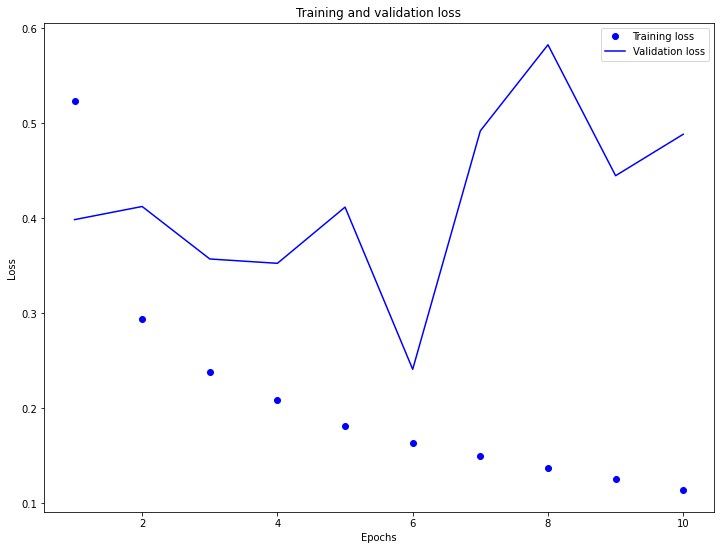

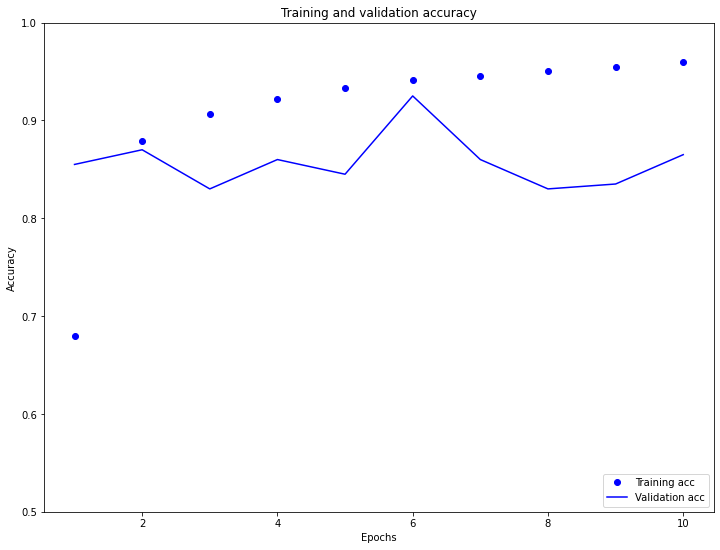

In [13]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss=history_dict['loss']
val_loss=history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

In [14]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(8185, 16)


In [15]:
import io

encoder = info.features['text'].encoder

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for num, word in enumerate(encoder.subwords):
  vec = weights[num+1] # skip 0, it's padding.
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

In [16]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

#Visualize the embeddings
To visualize our embeddings we will upload them to the embedding projector.

Open the [Embedding Projector](http://projector.tensorflow.org/) (this can also run in a local TensorBoard instance).

Click on "Load data".

Upload the two files we created above: vecs.tsv and meta.tsv.

The embeddings you have trained will now be displayed. You can search for words to find their closest neighbors. For example, try searching for "beautiful". You may see neighbors like "wonderful".